In [ ]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import f1_score, mean_squared_error

Multinomial

In [ ]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
filename = 'bna_train.csv'
data = pd.read_csv(filename)
y = data['class']
X = data.drop(labels=['class'], axis=1)
test = pd.read_csv('bna_test.csv')
y_test = pd.read_csv('bna_test.csv')['class']
X_test = pd.read_csv('bna_test.csv').drop(labels=['class'], axis=1)

print(X)

      variance  skewness  curtosis   entropy
0     -2.64060   -4.4159    5.9830 -0.139240
1      0.96441    5.8395    2.3235  0.066365
2     -2.12410   -6.8969    5.5992 -0.471560
3      2.31360   10.6651   -3.5288 -4.767200
4     -0.53900   -5.1670    3.4399  0.052141
...        ...       ...       ...       ...
1092   2.52270    2.2369    2.7236  0.794380
1093   3.65750    7.2797   -2.2692 -1.144000
1094  -1.81870   -9.0366    9.0162 -0.122430
1095  -4.28590    8.5234    3.1392 -0.916390
1096   3.77980   -3.3109    2.6491  0.066365

[1097 rows x 4 columns]


In [ ]:
for i in range(len(X['variance'])):
  X['variance'][i] += 15
for j in range(len(X['skewness'])):
  X['skewness'][j] += 15
for k in range(len(X['curtosis'])):
  X['curtosis'][k] += 15
for l in range(len(X['entropy'])):
  X['entropy'][l] += 15

print(X)

      variance  skewness  curtosis    entropy
0     12.35940   10.5841   20.9830  14.860760
1     15.96441   20.8395   17.3235  15.066365
2     12.87590    8.1031   20.5992  14.528440
3     17.31360   25.6651   11.4712  10.232800
4     14.46100    9.8330   18.4399  15.052141
...        ...       ...       ...        ...
1092  17.52270   17.2369   17.7236  15.794380
1093  18.65750   22.2797   12.7308  13.856000
1094  13.18130    5.9634   24.0162  14.877570
1095  10.71410   23.5234   18.1392  14.083610
1096  18.77980   11.6891   17.6491  15.066365

[1097 rows x 4 columns]


In [ ]:
clf = MultinomialNB()
clf.fit(X, y)
print(f'training accuracy: {clf.score(X, y)}')
print(f'testing accuracy: {clf.score(X_test, y_test)}')
print(f'testing f1: {f1_score(clf.predict(X_test), y_test)}')

training accuracy: 0.6435733819507748
testing accuracy: 0.5527272727272727
testing f1: 0.4533333333333333


Multi-Variant Bernoulli

In [ ]:
train = pd.read_csv('bna_train.csv')
test = pd.read_csv('bna_test.csv')

clf = BernoulliNB()
X_train = train.drop(columns=['class'])
y_train = train['class']
clf.fit(X_train, y_train)

BernoulliNB()

In [ ]:
print(f'training accuracy: {clf.score(X_train, y_train)}')
print(f"testing accuracy: {clf.score(test.drop(columns=['class']), test['class'])}")
print(f'testing f1: {f1_score(clf.predict(X_test), y_test)}')

training accuracy: 0.853236098450319
testing accuracy: 0.8072727272727273
testing f1: 0.7854251012145749


Poisson

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
from math import e

{'curtosis': {0: 1.8901009990887059, 1: 1.0638604387670858},
 'entropy': {0: 0.662211333800739, 1: 0.5729127834816039},
 'skewness': {0: 8.352876539645836, 1: 2.853038190589336},
 'variance': {0: 3.0508196783854062, 1: 0.6402026060288016}}

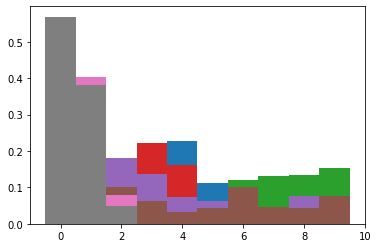

In [ ]:
params = {}
classes = set(data['class'])

for col in data.columns[:-1]:
  for c in classes:
    current = data[data['class'] == c][col]
    # the bins should be of integer width, because poisson is an integer distribution
    bins = np.arange(11) - 0.5
    entries, bin_edges, patches = plt.hist(current, bins=bins, density=True, label='Data')

    # calculate bin centres
    bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])


    def fit_function(k, lamb):
        '''poisson function, parameter lamb is the fit parameter'''
        return poisson.pmf(k, lamb)


    # fit with curve_fit
    parameters, cov_matrix = curve_fit(fit_function, bin_middles, entries)
    if col not in params:
      params[col] = {}
    params[col][c] = parameters[0]
params

In [ ]:
def poissonpdf(k, l):
  return ((l**k)*(e**-l)/factorial(int(k)))

def runPoisson(df):
  df['clf'] = None

  idx = 0
  for idx in df.index:
    current = df.iloc[idx]

    probabilities = {}
    for c in classes:
      total = 0
      for col in current.index:
        if col == 'class' or col == 'clf': continue
        total += poissonpdf(current[col], params[col][c])
      probabilities[c] = total
    df.loc[idx, 'clf'] = max(probabilities, key=probabilities.get)
  return df

In [ ]:
from sklearn.metrics import mean_squared_error
train = runPoisson(train)
print(f"training accuracy: {mean_squared_error(train['class'], train['clf'])}")
test = runPoisson(test)
print(f"testing accuracy: {mean_squared_error(test['class'], test['clf'])}")

print(f"testing f1: {f1_score(list(test['class']), list(test['clf']))}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


training accuracy: 0.5177757520510483


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


testing accuracy: 0.52
testing f1: 0.089171974522293
